In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pfjax as pf
import pfjax.sde as sde

key = random.PRNGKey(0)

## Model

The Jump-Diffusion model is the following:

$$
\begin{aligned}
Z_{t+\Delta t} &= Z_t + (\theta + \kappa Z_t) \Delta t + \sigma_z \sqrt{Z_t} \Delta W_t^z + V_{t+\Delta t}^z J_{t+\Delta t} \\
X_{t+\Delta t} &= X_t + \alpha \Delta t + \sqrt{Z_t} \Delta W_t^x + V_{t+\Delta t}^x J_{t+\Delta t} 
\end{aligned}
$$

where

$$
\begin{aligned}
\Delta W_t^x, \Delta W_t^z &\sim \textrm{iid } N(0, \Delta t) \\
V_t^z &\sim \exp(\mu_z) \\
V_t^x &\sim N(\mu_x, \sigma^2_x) \\
J_{t+\Delta t} &\sim \textrm{Bern}(\lambda \Delta t).
\end{aligned}
$$

Thus, our parameters are $\Theta = (\alpha, \theta, \kappa, \sigma_z, \lambda,\mu_x, \sigma_x, \mu_z)$, observation is $X_t$ (the logarithm of asset price), and latent state $Z_t$ (unobserved volatility).

In [2]:
def euler_sim_jump(key, x, dt, drift, diff, jump, theta):
    """
    Simulate SDE with dense diffusion using Euler-Maruyama discretization.
    Args:
        key: PRNG key.
        x: Initial value of the SDE.  A vector of size `n_dims`.
        dt: Interobservation time.
        drift: Drift function having signature `drift(x, theta)` and returning a vector of size `n_dims`.
        diff: Diffusion function having signature `diff(x, theta)` and returning a vector of size `n_dims`.
        theta: Parameter value.
    Returns:
        Simulated SDE values. A vector of size `n_dims`.
    """
    
    diff_process = jax.random.multivariate_normal(
        key,
        mean= x[0:2] + drift(x[0:2], theta) * dt,
        cov=diff(x[0:2], theta) * dt
    )
    vz_param, vx_param, lam = jump(theta)
    isjump = jax.random.bernoulli(key, p=lam*dt)
    jumpsize = jnp.where(isjump==1.0, 
                         jnp.array([vz_param*jax.random.exponential(key), 
                                    vx_param[0]+vx_param[1]*jax.random.normal(key)]),
                         jnp.array([0.0,0.0]))
    jump_process = jumpsize * isjump
    
    return jnp.append(diff_process + jump_process, jumpsize)

class SDEModel_tmp(object):
    
    def __init__(self, dt, n_res, meas_model="Error-free"):
        self._dt = dt
        self._n_res = n_res
        self._meas_model = meas_model
        
        def euler_sim(self, key, x, dt, theta):
            return euler_sim_jump(key, x, dt, self.drift, self.diff, self.jump, theta)
        
        setattr(self.__class__, 'euler_sim', euler_sim)
    
    def state_sample(self, key, x_prev, theta):
        def fun(carry, t):
            key, subkey = random.split(carry["key"])
            x = self.euler_sim(
                key=subkey, x=carry["x"],
                dt=self._dt/self._n_res, theta=theta
            )
            res = {"x": x, "key": key}
            return res, x
        init = {"x": x_prev[-1], "key": key}
        last, full = lax.scan(fun, init, jnp.arange(self._n_res))
        return full

In [3]:
class JumpDiff(SDEModel_tmp):
    
    def __init___(self, dt, n_res, bootstrap=False):
        self._dt = dt
        self._n_res = n_res
        
    def drift(self, x, theta):
        mu = jnp.array([theta[1]+theta[2]*x[0], theta[0]])
        return mu
    
    def diff(self, x, theta):
        Sigma = jnp.array([[x[0]*(theta[3]**2),0],[0,x[0]]])
        return Sigma
    
    def jump(self, theta):
        vx_param = jnp.array([theta[5], theta[6]])
        vz_param = theta[7]
        lam = theta[4]
        return vz_param, vx_param, lam
    
    def meas_sample(self, key, x_curr, theta):
        return x_curr[-1][1]

In [18]:
key = random.PRNGKey(1)

dt = 1
n_res = 5
n_obs = 100
theta = jnp.array([0.08, 0.02, -0.03, 0.12, 0.2, -3.1, 2.7, 1.7])
x_init = jnp.block([[jnp.zeros((n_res-1, 4))],
                    [jnp.array([2.0, 100.0,0,0])]])

jdmodel = JumpDiff(dt, n_res)

In [5]:
y_meas, x_state = pf.simulate(jdmodel, key, n_obs, x_init, theta)


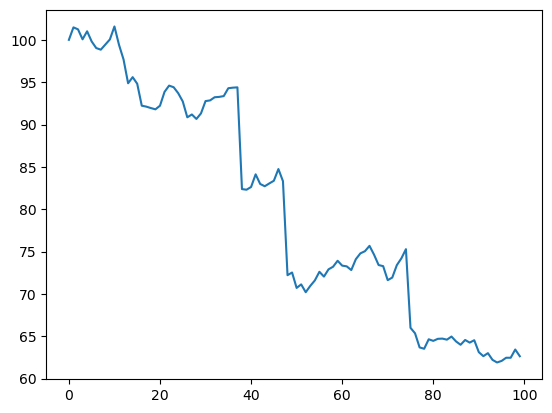

In [6]:
plt.plot(y_meas)

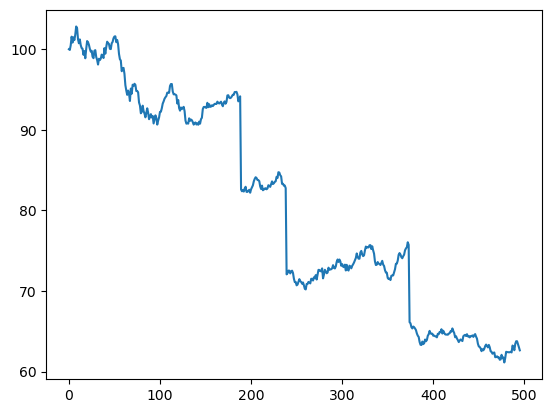

In [7]:
plt.plot(x_state[:,:,1].reshape(n_res*n_obs,1)[(n_res-1):])
#plt.plot(y_meas[:,])

In [8]:
def bridge_param(x, y_curr, theta, n, vz, vx, vx_invcumsum, dt, n_res):
    k = n_res - n
    dt_res = dt/n_res
    
    mu_z = x[0] + (theta[1]+theta[2]*x[0])*dt_res + vz
    sig2_z = x[0]*(theta[3]**2)*dt_res
    
    mu_x = x[1] + (y_curr - x[1])/k + vx - vx_invcumsum/k
    sig2_x = (k - 1)/k*x[0]*dt_res
    
    return mu_z, sig2_z, mu_x, sig2_x

In [9]:
def bridge_step(key, x_prev, y_curr, theta):
        
    def scan_fun(carry, t):
        key = carry["key"]
        x = carry["x"]
        
        n, vz, vx, vx_invcumsum = t
        mu_z, sig2_z, mu_x, sig2_x = bridge_param(x, y_curr, theta, n, vz, vx, vx_invcumsum, dt, n_res)

        mu_bridge = jnp.array([mu_z, mu_x])
        Sigma_bridge = jnp.array([[sig2_z, 0],[0, sig2_x]])

        key, subkey = random.split(key)

        x_prop = jnp.where(n<n_res-1, 
                           #random.multivariate_normal(key, mean=mu_bridge, cov=Sigma_bridge),
                           jnp.array([mu_z + jnp.sqrt(sig2_z) * random.normal(key), 
                                      mu_x + jnp.sqrt(sig2_x) * random.normal(key),
                                      vz,
                                      vx]),
                           jnp.array([mu_z + jnp.sqrt(sig2_z) * random.normal(key), 
                                      y_curr,
                                      vz,
                                      vx])
                           #jnp.array([mu_z + jnp.sqrt(sig2_z) * random.normal(key), y_curr])
                          )
        
        lp_prop_z = jsp.stats.norm.logpdf(x=x_prop[0], loc=mu_z, scale=jnp.sqrt(sig2_z))
        lp_prop_x = jnp.where(n<n_res-1,
                              jsp.stats.norm.logpdf(x=x_prop[1], loc=mu_x, scale=jnp.sqrt(sig2_x)),
                              0.0
                             )
        lp_prop = lp_prop_z + lp_prop_x
        
        res_carry = {
            "x": x_prop,
            "key": key,
            "lp": carry["lp"] + lp_prop,
            "lp_z": carry["lp_z"] + lp_prop_z,
            "lp_x": carry["lp_x"] + lp_prop_x
        }

        res_stack = {"x": x_prop, "lp":lp_prop, "lp_z": lp_prop_z, "lp_x": lp_prop_x}

        return res_carry, res_stack
    
    scan_init = {
        "x": x_prev[n_res-1],
        "key": key,
        "lp": jnp.array(0.),
        "lp_z": jnp.array(0.),
        "lp_x": jnp.array(0.)
    }
    
    ns = jnp.arange(n_res)
    jumps = jax.random.bernoulli(key, shape=(n_res,), p=theta[4]*dt/n_res)
    vzs = jax.vmap(lambda x: jnp.where(x, theta[7]*jax.random.exponential(key), 0.0))(jumps)
    vxs = jax.vmap(lambda x: jnp.where(x, theta[5]+theta[6]*jax.random.normal(key), 0.0))(jumps)
    vxs_invcumsum = jax.lax.cumsum(vxs[::-1])[::-1]
    
    last, full = lax.scan(scan_fun, scan_init, (ns,vzs,vxs,vxs_invcumsum))
    
    x_prop = full["x"]
    
    logw_trans = state_lpdf(
        x_curr=x_prop,
        x_prev=x_prev, 
        theta=theta
    )
    
    logw = logw_trans - full["lp"]
    
    return x_prop, logw, logw_trans, full["lp"], full["lp_z"], full["lp_x"]

In [10]:
def bridge_step2(key, x_prev, y_curr, theta):
        
    def scan_fun(carry, t):
        key = carry["key"]
        x = carry["x"]
        
        n, vz, vx, vx_invcumsum = t
        mu_z, sig2_z, mu_x, sig2_x = bridge_param(x, y_curr, theta, n, vz, vx, vx_invcumsum, dt, n_res)

        key, subkey = random.split(key)

        x_prop = jnp.where(n<n_res-1, 
                           #random.multivariate_normal(key, mean=mu_bridge, cov=Sigma_bridge),
                           jnp.array([mu_z + jnp.sqrt(sig2_z) * random.normal(key), 
                                      mu_x + jnp.sqrt(sig2_x) * random.normal(key),
                                      vz,
                                      vx]),
                           jnp.array([mu_z + jnp.sqrt(sig2_z) * random.normal(key), 
                                      y_curr,
                                      vz,
                                      vx])
                           #jnp.array([mu_z + jnp.sqrt(sig2_z) * random.normal(key), y_curr])
                          )

        lp_prop_x = jnp.where(n<n_res-1,
                              jsp.stats.norm.logpdf(x=x_prop[1], loc=mu_x, scale=jnp.sqrt(sig2_x)),
                              0.0
                             )
        
        res_carry = {
            "x": x_prop,
            "key": key,
            "lp_x": carry["lp_x"] + lp_prop_x
        }

        res_stack = {"x": x_prop, "lp_x":lp_prop_x}

        return res_carry, res_stack
    
    scan_init = {
        "x": x_prev[n_res-1],
        "key": key,
        "lp_x": jnp.array(0.)
    }
    
    # key, subkeys = jax.random.split(key, num=)
    
    ns = jnp.arange(n_res)
    jumps = jax.random.bernoulli(key, shape=(n_res,), p=theta[4]*dt/n_res)
    vzs = jax.vmap(lambda x: jnp.where(x, theta[7]*jax.random.exponential(key), 0.0))(jumps)
    vxs = jax.vmap(lambda x: jnp.where(x, theta[5]+theta[6]*jax.random.normal(key), 0.0))(jumps)
    vxs_invcumsum = jax.lax.cumsum(vxs[::-1])[::-1]
    
    last, full = lax.scan(scan_fun, scan_init, (ns,vzs,vxs,vxs_invcumsum))
    
    x_prop = full["x"]
    
    logw_trans = state_lpdf2(
        x_curr=x_prop,
        x_prev=x_prev, 
        theta=theta
    )
    
    logw = logw_trans - full["lp_x"]
    
    return x_prop, logw, logw_trans, full["lp_x"]

In [61]:
def drift(x, x_curr, theta, dt):
    mu = jnp.array([theta[1]+theta[2]*x[0], theta[0]]) * dt + jnp.array([x_curr[2], x_curr[3]])
    return mu
def diff(x, theta, dt):
    Sigma = jnp.array([[x[0]*(theta[3]**2),0],[0,x[0]]]) * dt
    return Sigma

In [67]:
def euler_lpdf_jump(x_curr, x_prev, dt, drift, diff, theta):
    return jsp.stats.multivariate_normal.logpdf(
        x=x_curr[0:2],
        mean=x_prev[0:2] + drift(x_prev, x_curr, theta, dt)[0:2],
        cov=diff(x_prev[0:2], theta, dt)
    ) 

def euler_lpdf_jump2(x_curr, x_prev, dt, drift, diff, theta):
    return jsp.stats.norm.logpdf(
        x=x_curr[1],
        loc=x_prev[1] + (drift(x_prev, x_curr, theta, dt))[1],
        scale=jnp.sqrt((diff(x_prev, theta, dt))[1,1])
    ) 

In [68]:
def state_lpdf(x_curr, x_prev, theta):
    x0 = jnp.concatenate([x_prev[-1][None], x_curr[:-1]])
    x1 = x_curr
    lp = jax.vmap(lambda xp, xc:
                  euler_lpdf_jump(
                      x_curr=xc, x_prev=xp,
                      dt=dt/n_res,
                      drift=drift,
                      diff=diff,
                      theta=theta))(x0, x1)
    return lp

def state_lpdf2(x_curr, x_prev, theta):
    x0 = jnp.concatenate([x_prev[-1][None], x_curr[:-1]])
    x1 = x_curr
    lp = jax.vmap(lambda xp, xc:
                  euler_lpdf_jump2(
                      x_curr=xc, x_prev=xp,
                      dt=dt/n_res,
                      drift=drift,
                      diff=diff,
                      theta=theta))(x0, x1)
    return lp


In [69]:
Y = 90.5
x_init = jnp.block([[jnp.zeros((n_res-1, 4))],
                    [jnp.array([2.0, 100.0,0.0,0.0])]])

In [86]:
x_prop, logw1, logw_trans1, lp1, lp_z1, lp_x1 = bridge_step(key, x_init, Y, theta)

In [87]:
x_prop2, logw2, logw_trans2, lp_x2 = bridge_step2(key, x_init, Y, theta)

In [88]:
bridge_step(key, x_init, Y, theta)

(DeviceArray([[ 1.9045547 , 98.70773   ,  0.        ,  0.        ],
              [ 2.1800199 , 92.43164   ,  0.21374707, -6.2975674 ],
              [ 2.2292078 , 92.18422   ,  0.        ,  0.        ],
              [ 2.156301  , 90.96775   ,  0.        ,  0.        ],
              [ 2.1452534 , 90.5       ,  0.        ,  0.        ]],            dtype=float32),
 DeviceArray([-1.5872457 ,  0.29194605, -0.01192856, -1.7357295 ,
              -0.76973045], dtype=float32),
 DeviceArray([-1.6045456 ,  0.8117125 ,  0.76253295, -0.9276583 ,
               0.851758  ], dtype=float32),
 DeviceArray([-0.01729989,  0.51976645,  0.7744615 ,  0.80807114,
               1.6214885 ], dtype=float32),
 DeviceArray([0.99569654, 1.2480959 , 1.3459945 , 1.2908778 , 1.6214885 ],            dtype=float32),
 DeviceArray([-1.0129964 , -0.7283294 , -0.57153296, -0.4828067 ,
               0.        ], dtype=float32))

In [89]:
bridge_step2(key, x_init, Y, theta)

(DeviceArray([[ 1.9045547 , 98.70773   ,  0.        ,  0.        ],
              [ 2.1800199 , 92.43164   ,  0.21374707, -6.2975674 ],
              [ 2.2292078 , 92.18422   ,  0.        ,  0.        ],
              [ 2.156301  , 90.96775   ,  0.        ,  0.        ],
              [ 2.1452534 , 90.5       ,  0.        ,  0.        ]],            dtype=float32),
 DeviceArray([-1.5872457 ,  0.29194626, -0.01192874, -1.7357297 ,
              -0.76973027], dtype=float32),
 DeviceArray([-2.6002421 , -0.43638316, -0.5834617 , -2.2185364 ,
              -0.76973027], dtype=float32),
 DeviceArray([-1.0129964 , -0.7283294 , -0.57153296, -0.4828067 ,
               0.        ], dtype=float32))

In [91]:
logw1 - logw2

DeviceArray([ 0.0000000e+00, -2.0861626e-07,  1.7881393e-07,
              2.3841858e-07, -1.7881393e-07], dtype=float32)

In [82]:
dt = 1
n_res = 5
n_obs = 100
theta = jnp.array([0.08, 0.02, -0.03, 0.12, 1.0, -3.1, 2.7, 1.7])
x_init = jnp.block([[jnp.zeros((n_res-1, 4))],
                    [jnp.array([2.0, 100.0,0,0])]])
